In [1]:
import numpy as np
import tensorflow as tf
from keras import layers, models, optimizers
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, Concatenate, Multiply
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D,MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import glob
from tqdm import tqdm
import cv2

KeyboardInterrupt: 

In [ ]:
def load_dataset(TRAINING_DIR,TESTING_DIR):
    
    train_datagen = ImageDataGenerator(rescale=1 / 255)
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      target_size=(64,64))
    test_datagen = ImageDataGenerator(rescale=1 / 255)
    test_generator = test_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=64,
                                                                class_mode='categorical',
                                                                target_size=(64,64))
    
    x_train, y_train = next(train_generator)
    shape = x_train.shape
    return train_generator,test_generator, shape

In [ ]:
train_dir = '../input/brain-tumor-classification-mri/Training'
test_dir = '../input/brain-tumor-classification-mri/Testing'
train,test,shape = load_dataset(train_dir,test_dir)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
shape

(64, 64, 64, 3)

In [ ]:
def do_salience(image, model, label, prefix):
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64,64))
  img = img/255.0
  expand_img = np.expand_dims(img, axis= 0)
  num_classes = 4
  expected_output = tf.one_hot([label] * expand_img.shape[0], num_classes)
  with tf.GradientTape() as tape : 
    inputs = tf.cast(expand_img, tf.float32)
    tape.watch(inputs) 
    predictions = model(inputs) 
    loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions) 
    print(predictions)
  gradients = tape.gradient(loss, inputs)
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1) 
  normalized_tensor = tf.cast(255* (grayscale_tensor - tf.reduce_min(grayscale_tensor))/ 
                              (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),tf.uint8,) 
  normalized_tensor = tf.squeeze(normalized_tensor)
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalized_tensor, cmap='gray')
  plt.show()
  salient_image_name = prefix + image
  normalized_tensor = tf.expand_dims(normalized_tensor, -1)
  normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  writer = tf.io.write_file(salient_image_name, normalized_tensor)

# **CNN Based Classifier**

In [ ]:
def CNN():
    model = tf.keras.models.Sequential([
    Input(shape=(shape[1], shape[2], shape[3])),
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
    ])
    return model
   

In [ ]:
Cnn_classifier = CNN()

2022-04-19 10:34:08.569434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 10:34:08.658661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 10:34:08.659352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 10:34:08.660461: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
Cnn_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3211520   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [ ]:
Cnn_classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

In [ ]:
Cnn_classifier.save('0_epochs.h5')

2022-04-19 10:34:25.440190: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


tf.Tensor([[0.21931927 0.24180931 0.25012738 0.288744  ]], shape=(1, 4), dtype=float32)


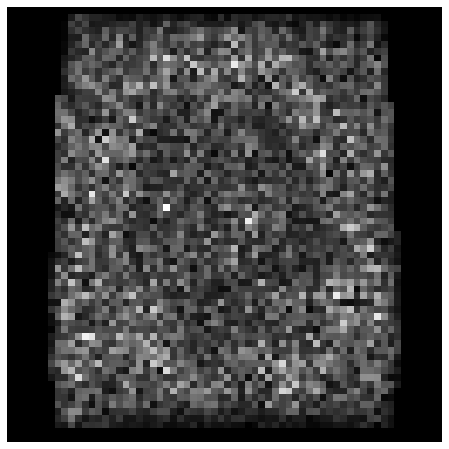

tf.Tensor([[0.21021332 0.239591   0.25654572 0.29364997]], shape=(1, 4), dtype=float32)


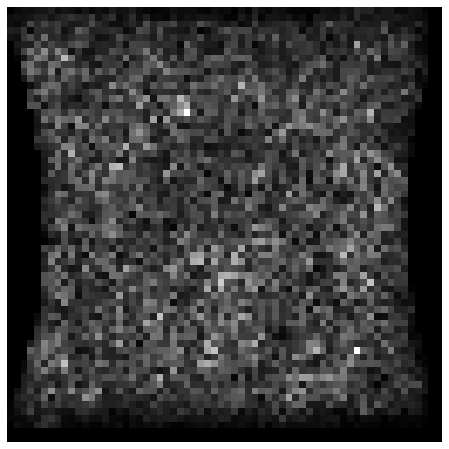

tf.Tensor([[0.20212777 0.2362426  0.25642705 0.30520254]], shape=(1, 4), dtype=float32)


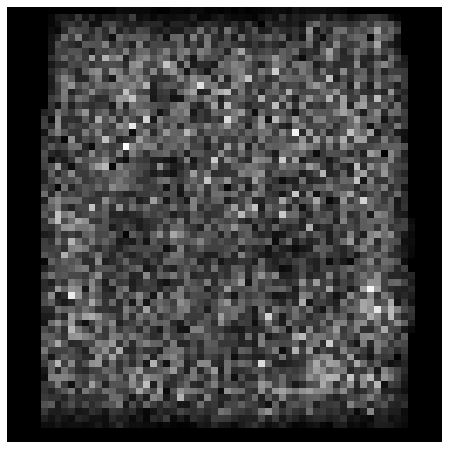

In [ ]:
Cnn_classifier.load_weights('./0_epochs.h5')
do_salience('../input/sailency/gg.jpg',Cnn_classifier,0, 'epoch0_salient') 
do_salience('../input/sailency/m.jpg',Cnn_classifier, 1, 'epoch0_salient') 
do_salience('../input/sailency/p.jpg',Cnn_classifier, 3, 'epoch0_salient')  

In [ ]:
Cnn_classifier.fit(train,validation_data=test,epochs=20,verbose=1)

2022-04-19 10:34:41.657519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
45/45 [==============================] - 25s 545ms/step - loss: 1.0850 - accuracy: 0.5418 - val_loss: 1.8501 - val_accuracy: 0.2766
Epoch 2/20
45/45 [==============================] - 11s 255ms/step - loss: 0.8076 - accuracy: 0.6666 - val_loss: 1.6913 - val_accuracy: 0.4594
Epoch 3/20
45/45 [==============================] - 11s 246ms/step - loss: 0.6806 - accuracy: 0.7310 - val_loss: 2.1126 - val_accuracy: 0.4670
Epoch 4/20
45/45 [==============================] - 11s 254ms/step - loss: 0.5899 - accuracy: 0.7784 - val_loss: 2.0797 - val_accuracy: 0.4797
Epoch 5/20
45/45 [==============================] - 11s 245ms/step - loss: 0.5176 - accuracy: 0.8101 - val_loss: 2.0463 - val_accuracy: 0.5457
Epoch 6/20
45/45 [==============================] - 11s 252ms/step - loss: 0.4699 - accuracy: 0.8321 - val_loss: 2.1007 - val_accuracy: 0.5584
Epoch 7/20
45/45 [==============================] - 11s 255ms/step - loss: 0.4266 - accuracy: 0.8397 - val_loss: 1.9738 - val_accuracy: 0.6066

In [ ]:
Cnn_classifier.save('20_epochs.h5')

tf.Tensor([[9.9527186e-01 2.4228216e-04 1.2161573e-04 4.3642595e-03]], shape=(1, 4), dtype=float32)


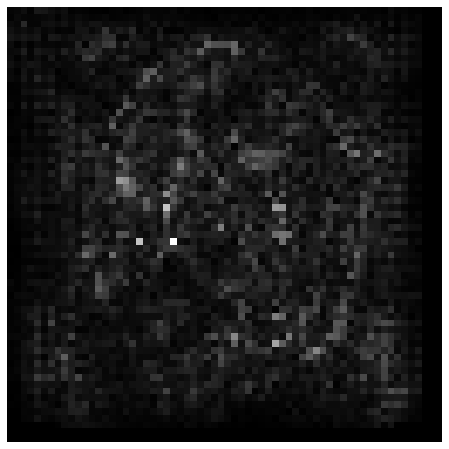

tf.Tensor([[2.7164486e-01 7.2501612e-01 3.3384229e-03 5.6845431e-07]], shape=(1, 4), dtype=float32)


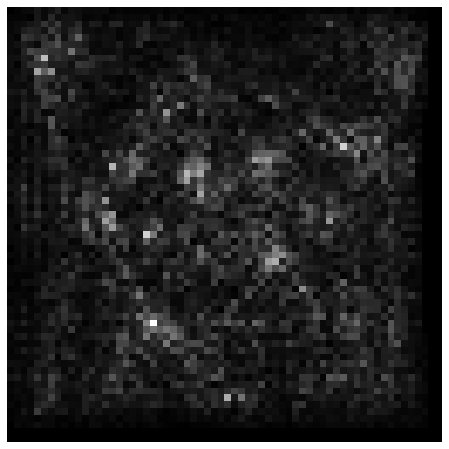

tf.Tensor([[2.0397660e-04 3.7193981e-01 4.0349853e-03 6.2382120e-01]], shape=(1, 4), dtype=float32)


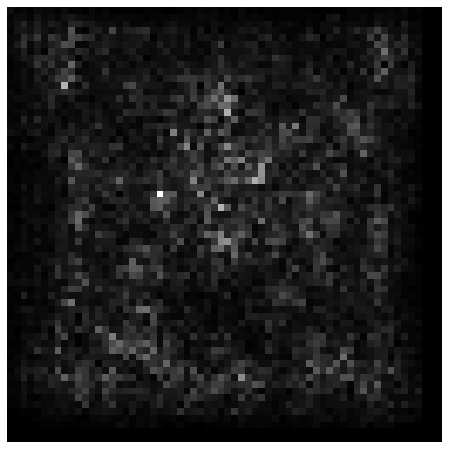

In [ ]:
Cnn_classifier.load_weights('./20_epochs.h5')
do_salience('../input/sailency/gg.jpg',Cnn_classifier,0, 'epoch20_salient') 
do_salience('../input/sailency/m.jpg',Cnn_classifier, 1, 'epoch20_salient') 
do_salience('../input/sailency/p.jpg',Cnn_classifier, 3, 'epoch20_salient')  

# **Capsule based classifier**

In [ ]:
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [ ]:
def build_discriminator(n_routings=3):
    img = Input(shape=(shape[1], shape[2], shape[3]))
    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv2')(img)
    x = LeakyReLU()(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Flatten()(x)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    for i in range(n_routings):
        c = Activation('softmax', name='softmax_digitcaps'+str(i))(uhat)
        c = Dense(160)(c)
        x = Multiply()([uhat, c])
        s_j = LeakyReLU()(x)
    x = Dense(32,activation='relu')(s_j)
    pred = Dense(4, activation='softmax')(x)
    return Model(img, pred)

In [ ]:
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

DISCRIMINATOR:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 56, 56, 256)  62464       input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 56, 56, 256)  0           conv2[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 256)  1024        leaky_re_lu[0][0]                
_______________________________________________________________________________

In [ ]:
discriminator.save("capsule_0epoch.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


tf.Tensor([[0.24999869 0.25000134 0.24999869 0.25000128]], shape=(1, 4), dtype=float32)


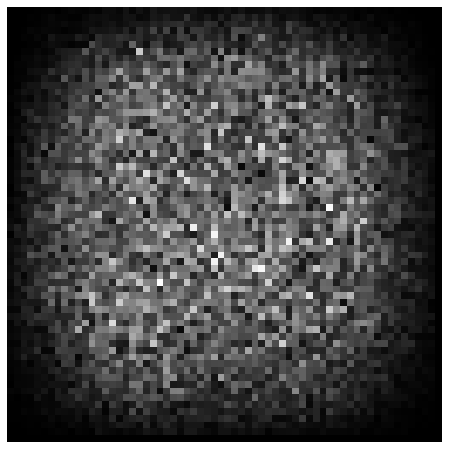

tf.Tensor([[0.24999762 0.24999765 0.2500045  0.25000024]], shape=(1, 4), dtype=float32)


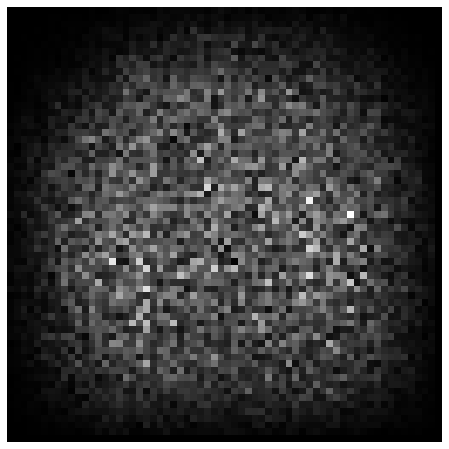

tf.Tensor([[0.24999495 0.2500024  0.25000492 0.24999772]], shape=(1, 4), dtype=float32)


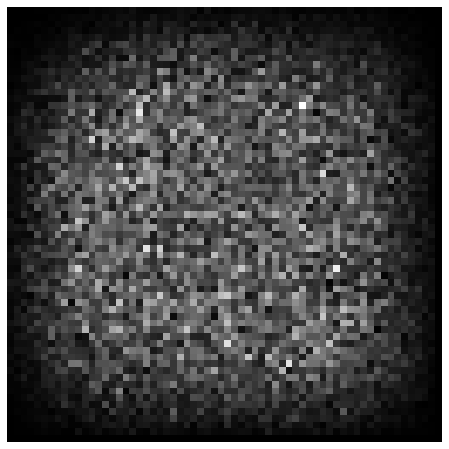

In [ ]:
discriminator.load_weights('./capsule_0epoch.h5')
do_salience('../input/sailency/gg.jpg',discriminator,0, 'capsuleepoch0_salient') 
do_salience('../input/sailency/m.jpg',discriminator, 1, 'capsuleepoch0_salient') 
do_salience('../input/sailency/p.jpg',discriminator, 3, 'capsuleepoch0_salient')  

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
discriminator.fit(train,validation_data=test,epochs=20,verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
45/45 [==============================] - 16s 326ms/step - loss: 1.0245 - accuracy: 0.5666 - val_loss: 2.6699 - val_accuracy: 0.2817
Epoch 2/20
45/45 [==============================] - 13s 293ms/step - loss: 0.8284 - accuracy: 0.6798 - val_loss: 1.6488 - val_accuracy: 0.3680
Epoch 3/20
45/45 [==============================] - 13s 291ms/step - loss: 0.4585 - accuracy: 0.8247 - val_loss: 1.9054 - val_accuracy: 0.5178
Epoch 4/20
45/45 [==============================] - 14s 301ms/step - loss: 0.3007 - accuracy: 0.8913 - val_loss: 1.5555 - val_accuracy: 0.6244
Epoch 5/20
45/45 [==============================] - 13s 289ms/step - loss: 0.2753 - accuracy: 0.9003 - val_loss: 1.7840 - val_accuracy: 0.6218
Epoch 6/20
45/45 [==============================] - 14s 303ms/step - loss: 0.5732 - accuracy: 0.8042 - val_loss: 2.5544 - val_accuracy: 0.4340
Epoch 7/20
45/45 [==============================] - 13s 291ms/step - loss: 0.2336 - accuracy: 0.9122 - val_loss: 1.9568 - val_accuracy: 0.6878

In [ ]:
discriminator.save("capsule_20epoch.h5")

tf.Tensor([[9.9990201e-01 2.4651456e-05 7.3994531e-09 7.3276853e-05]], shape=(1, 4), dtype=float32)


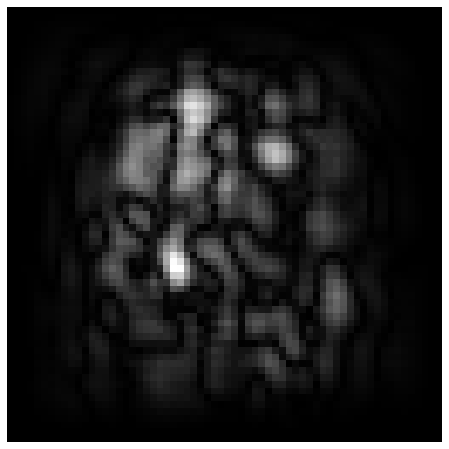

tf.Tensor([[4.9191882e-04 9.9788338e-01 1.4915974e-03 1.3309621e-04]], shape=(1, 4), dtype=float32)


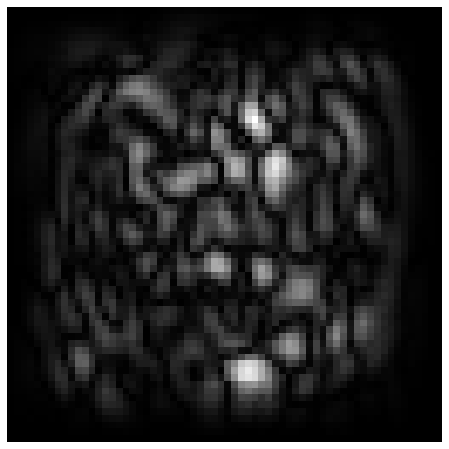

tf.Tensor([[2.6000643e-04 3.2239996e-03 5.7855633e-04 9.9593747e-01]], shape=(1, 4), dtype=float32)


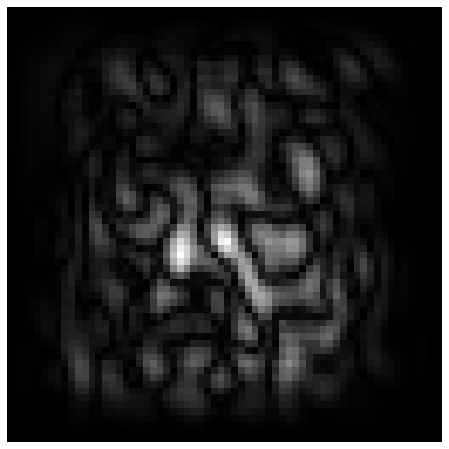

In [ ]:
discriminator.load_weights('./capsule_20epoch.h5')
do_salience('../input/sailency/gg.jpg',discriminator,0, 'capsuleepoch20_salient') 
do_salience('../input/sailency/m.jpg',discriminator, 1, 'capsuleepoch20_salient') 
do_salience('../input/sailency/p.jpg',discriminator, 3, 'capsuleepoch20_salient')  